# Computing the Optimal Grwoth Model by the Euler Equation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Model

Let's consider the optimal growth model,

\begin{align}
	&\max\int_{0}^{\infty}e^{-\rho t}u(c(t))dt \\
	&\text{subject to} \\
	&\qquad\dot{k}(t)=f(k(t))-\delta k(t)-c(t),\\
	&\qquad k(0):\text{ given.} \\
\end{align}

We will assume the following specific function forms when necessary 

\begin{align}
   u(c) &= \frac{c^{1-\theta}}{1-\theta}, \quad \theta > 0, \\
   f(k) &= A k^\alpha, \quad 0 < \alpha < 1, \quad A > 0
\end{align}


By using the Hamiltonian method, we have obtained the first-order dynamics of the economy

\begin{align}
    \dot{c} &= \theta^{-1} c [f'(k) - \delta - \rho] & \text{(EE)} \\
    \dot{k} &= f(k) - \delta k - c. & \text{(CA)}
\end{align}

(EE) is the Euler equation and (CA) the capital accumulation equation. 

Let's draw the phase diagram on your computer.

## $\dot c = 0$ locus (EE)

$\dot k = 0$ is equivalent to 

\begin{align}
   f'(k) = \delta + \rho
\end{align}

Thus, the locus is a vertical line which goes through $(k^*, 0)$, where $k^*$ is the unique value that satisfies $f'(k^*) = \delta + \rho$. Under the assumption that $f(k) = Ak^\alpha$, 

\begin{align}
 k^* = \left(\frac{\delta + \rho}{A \alpha}\right)^\frac{1}{\alpha - 1}
\end{align}

## $\dot k = 0$ locus (CA)

$\dot k = 0$ is equivalent to 

\begin{align}
   c = f(k) - \delta k.
\end{align}

## Code for the loci

In [2]:
alpha = 0.3
delta = 0.05
rho = 0.1
theta = 1

A = 1
def f(x):
    return A * x**alpha

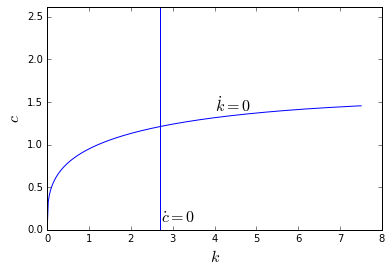

In [3]:
kgrid = np.linspace(0.0, 7.5, 300)

fig, ax = plt.subplots(1,1)

# Locus obtained from (EE)
kstar = ((delta + rho) / (A * alpha)) ** (1/(alpha - 1))
ax.axvline(kstar)
ax.text(kstar*1.01, 0.1, '$\dot c = 0$', fontsize=16)

# Locus obtained from (CA)
ax.plot(kgrid, f(kgrid) - delta * kgrid)
ax.text(4, 1.06*(f(4) - delta * 4), '$\dot k = 0$', fontsize=16)

# axis labels
ax.set_xlabel('$k$', fontsize=16)
ax.set_ylabel('$c$', fontsize=16)
ax.set_ylim([0.0, 1.8 * np.max(f(kgrid) - delta*kgrid)])

plt.show()

What we want to do is to draw paths on this phase space. It is convenient to have a function that returns this kind of figure. 

In [4]:
def phase_space(kmax, gridnum, yamp=1.8, colors=['black', 'black'], labels_on=False):

    kgrid = np.linspace(0.0, kmax, gridnum)

    fig, ax = plt.subplots(1,1)

    # EE locus
    ax.plot(kgrid, f(kgrid) - delta * kgrid, color=colors[0])
    if labels_on:
        ax.text(4, f(4) - delta * 4, '$\dot k = 0$', fontsize=16)
    

    # CA locus
    kstar = ((delta + rho) / (A * alpha)) ** (1/(alpha - 1))
    ax.axvline(kstar, color=colors[1])
    if labels_on:
        ax.text(kstar*1.01, 0.1, '$\dot c = 0$', fontsize=16)

    # axis labels
    ax.set_xlabel('$k$', fontsize=16)
    ax.set_ylabel('$c$', fontsize=16)
        
    ax.set_ylim([0.0, yamp * np.max(f(kgrid) - delta*kgrid)])

    return fig, ax

You can draw the loci by calling the function as in the following.

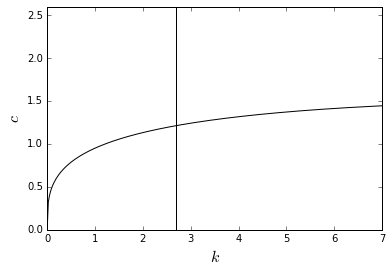

In [5]:
fig, ax = phase_space(kmax=7, gridnum=300)

## The dynamics

Discretize 

\begin{align}
    \dot{c} &= \theta^{-1} c [f'(k) - \delta - \rho] & \text{(EE)} \\
    \dot{k} &= f(k) - \delta k - c. & \text{(CA)}
\end{align}

to get the discretized dynamic equations:

\begin{align}
    c(t+\Delta t) &= c(t)\{1 + \theta^{-1} [f'(k(t)) - \delta - \rho] \Delta t\}& \text{(D-EE)} \\
    k(t+\Delta t) &= k(t) + \{f(k(t)) - \delta k(t) - c(t)\} \Delta t. & \text{(D-CA)}
\end{align}

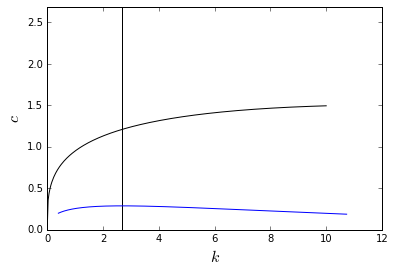

In [6]:
dt = 0.001

def f_deriv(k):
    """derivative of f"""
    return A * alpha * k ** (alpha - 1)

def update(k, c):
    cnew = c * (1 + (f_deriv(k) - delta - rho) * dt / theta)  # D-EE
    knew = k + (f(k) - delta * k - c) * dt
    return knew, cnew


k_initial, c_guess = 0.4, 0.2

# Find a first-order path from the initial condition k0 and guess of c0
k0, c0 = k_initial, c_guess

k, c = [k0], [c0]

for i in range(10000):
    knew, cnew = update(k[-1], c[-1])
    k.append(knew)
    c.append(cnew)
    
kgrid = np.linspace(0.0, 10., 300)

fig, ax = phase_space(10., 300)
ax.plot(k, c)

The blue curve shows the dynamic path of the system of differential equation. The solution moves from left to right in this case. This path doesn't seem to satisfy the transversality condition and so it's not the optimal path.


What we do next is to find $c(0)$ that converges to the steady state. I will show you how to do this by “brute force.”

Make many guesses about $c(0)$ and find the solution. We need to make a function to create a path that starts from $(k(0), c(0))$ and verify whether or not it's approaching to the steady state.

In [7]:
def compute_path(k0, c_guess, steps, ax=None, output=True):
    """compute a path starting from (k0, c_guess) that satisfies EE and CA"""
    
    k, c = [k0], [c_guess]
    for i in range(steps):
        knew, cnew = update(k[-1], c[-1])
        
        # stop if the new values violate nonnegativity constraints
        if knew < 0:
            break
        if cnew < 0:
            break
        
        k.append(knew)
        c.append(cnew)
        
    # plot the path if ax is given
    if ax is not None:
        ax.plot(k, c)
    
    # You may want to suppress the output when you give ax.
    if output:
        return k, c

Typical usage: 

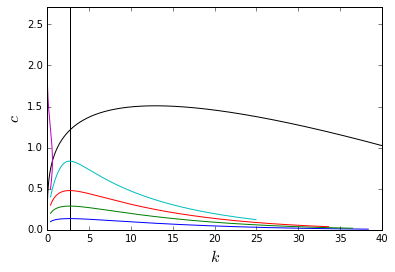

In [8]:
k_init = 0.4
steps = 30000

fig, ax = phase_space(40, 3000)

for c_init in [0.1, 0.2, 0.3, 0.4, 0.5]:
    compute_path(k_init, c_init, steps, ax, output=False)

Let's find the optimal path. The following code makes a plot that relates a guess of $c(0)$ to the final $c(t)$ and $k(t)$ for large $t$. 

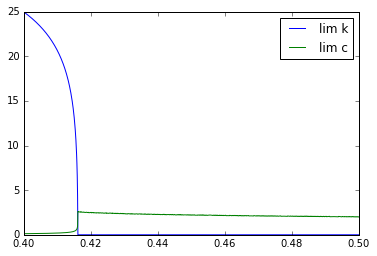

In [9]:
k_init = 0.4
steps = 30000

# set of guesses about c(0)
c_guess = np.linspace(0.40, 0.50, 1000)

k_final = []
c_final = []
for c0 in c_guess:
    k, c = compute_path(k_init, c0, steps, output=True)
    
    # Final values
    k_final.append(k[-1])
    c_final.append(c[-1])
    
plt.plot(c_guess, k_final, label='lim k')
plt.plot(c_guess, c_final, label='lim c')
plt.legend()

As you can clearly see, there is a critical value around 0.41. To know the exact value of the threshold, execute the following code.

In [10]:
cdiff = [c1 - c0 for c0, c1 in zip(c_final[:-1], c_final[1:])]
c_optimal = c_guess[cdiff.index(max(cdiff))]
c_optimal

0.41601601601601601

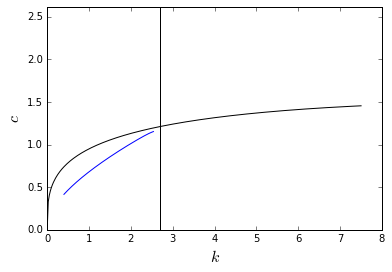

In [11]:
fig, ax = phase_space(7.5, 300)
compute_path(k_init, c_optimal, steps=15000, ax=ax, output=False)

It still doesn't converge, which you can see if you make step size larger. 

As a matter of fact this is the limitation of the method presented here. Moving along the optimal path is like walking on a narrow ridge of a mountain. A simulation of the optimal path as above is like rolling a pebble along the ridge. Even if you made the best shot, it would certainly fall down to the lower ground because of a small misstep or of bumpy surface; in computer simulation such errors are inevitable due to the internal representation (approximation) of real numbers.

You don't want to use it in practice.

Instead, we usually employ the dynamic programing approach for which stability of the algorithm is known. That is beyond the scope of this course.